In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input,Embedding, Dense, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model

# Dataset

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-03-17 12:39:51--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.1s    

2023-03-17 12:39:52 (3.59 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [5]:
df = pd.read_csv('spam.csv', encoding ='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [8]:
df.columns = ['labels', 'data'] #column name change
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
#create binary labels
#The **map()** function applies a function to every element in the series or dataframe
#and returns a new series or dataframe with the transformed values. 
#It can be used with a dictionary, a function, or a series.

df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
#split data
X_train, X_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.33) 

# Preprocessing

In [12]:
#Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx) #unique number of token
V

7277

In [19]:
# Pad sequences so that we get N x T matrix
data_train = pad_sequences(sequences_train)
data_train,data_train.shape
 

(array([[   0,    0,    0, ...,  760,  486,   14],
        [   0,    0,    0, ...,   58,  544,   84],
        [   0,    0,    0, ...,   57,    3, 3437],
        ...,
        [   0,    0,    0, ...,  170,   18, 7276],
        [   0,    0,    0, ...,    1,   86,   14],
        [   0,    0,    0, ...,  115,  250,  926]], dtype=int32), (3733, 189))

In [18]:
# get sequence length
T = len(data_train[1])
#T = data_train.shape[1]
T 

189

In [20]:
data_test = pad_sequences(sequences_test, maxlen=T)
data_test.shape

(1839, 189)

# Model Instantiate

In [21]:
D = 20 # Embedding dimensionality
M = 15 # hidden state dimensionality

#Note: First index start from 1. so, if embedding matrix size = V,
#then, it actually must have size V+1

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i,x)


In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
r = model.fit(data_train, Y_train, validation_data=(data_test, Y_test), epochs=5)

Epoch 1/5
117/117 [==============================] - 24s 185ms/step - loss: 0.0147 - accuracy: 0.9971 - val_loss: 0.0450 - val_accuracy: 0.9869
Epoch 2/5
117/117 [==============================] - 16s 136ms/step - loss: 0.0100 - accuracy: 0.9981 - val_loss: 0.0461 - val_accuracy: 0.9891
Epoch 3/5
117/117 [==============================] - 16s 134ms/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 0.0430 - val_accuracy: 0.9897
Epoch 4/5
117/117 [==============================] - 22s 188ms/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.0428 - val_accuracy: 0.9902
Epoch 5/5
117/117 [==============================] - 16s 136ms/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.0412 - val_accuracy: 0.9918


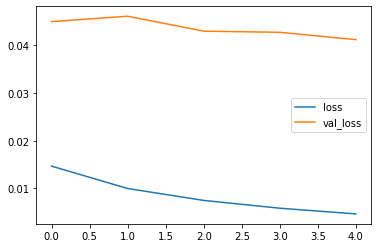

In [25]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


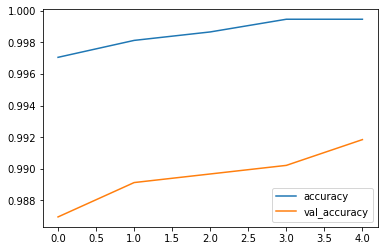

In [26]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()